# Data Exporation

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
movie_df = pd.read_csv('u.item', sep='|', header=None, encoding='latin1', index_col=False,
                   names=['movie_id',
                          'movie_title',
                          'release_date',
                          'video_release_date',
                          'imdb_url',
                          'unknown',
                          'action',
                          'adventure',
                          'animation',
                          'children',
                          'comedy',
                          'crime',
                          'documentary',
                          'drama',
                          'fantasy',
                          'film_noir',
                          'horror',
                          'musical',
                          'mystery'
                          'romance',
                          'sci_fi',
                          'thriller',
                          'war',
                          'western'])

movie_df.movie_id -= 1 # make this column zero-indexed

In [3]:
rating_df = pd.read_csv('u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'])
rating_df.user_id -= 1 # make this column zero-indexed
rating_df.movie_id -= 1 # make this column zero-indexed

In [4]:
rating_df.head()

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [5]:
movie_counts = rating_df.groupby('movie_id')['rating'].count().sort_values(ascending=False)

In [9]:

n_movies = 20
top_n_movies = rating_df.query('movie_id in {}'.format((movie_counts[:n_movies].index.values.tolist())))

In [10]:
# add the movie title for ease of access when plotting
# remove the timestamp column because we don't need it
top_n_movies = top_n_movies.merge(movie_df[['movie_id','movie_title']], on='movie_id', how='left') \
                           .drop(columns=['timestamp'])

In [11]:
#look at top 50 highest rated movies 
top_n_movies.movie_title.unique().tolist()

['Star Trek: First Contact (1996)',
 'Toy Story (1995)',
 'Silence of the Lambs, The (1991)',
 'Fargo (1996)',
 'Return of the Jedi (1983)',
 'Scream (1996)',
 'Jerry Maguire (1996)',
 'Liar Liar (1997)',
 'Raiders of the Lost Ark (1981)',
 'Rock, The (1996)',
 'Contact (1997)',
 'Empire Strikes Back, The (1980)',
 'Godfather, The (1972)',
 'Twelve Monkeys (1995)',
 'Pulp Fiction (1994)',
 'English Patient, The (1996)',
 'Star Wars (1977)',
 'Independence Day (ID4) (1996)',
 'Air Force One (1997)',
 'Titanic (1997)']

In [12]:
rating_counts_by_movie = top_n_movies.groupby(['movie_id','movie_title','rating'], as_index=False) \
                                        .size().to_frame('count') \
                                        .reset_index()

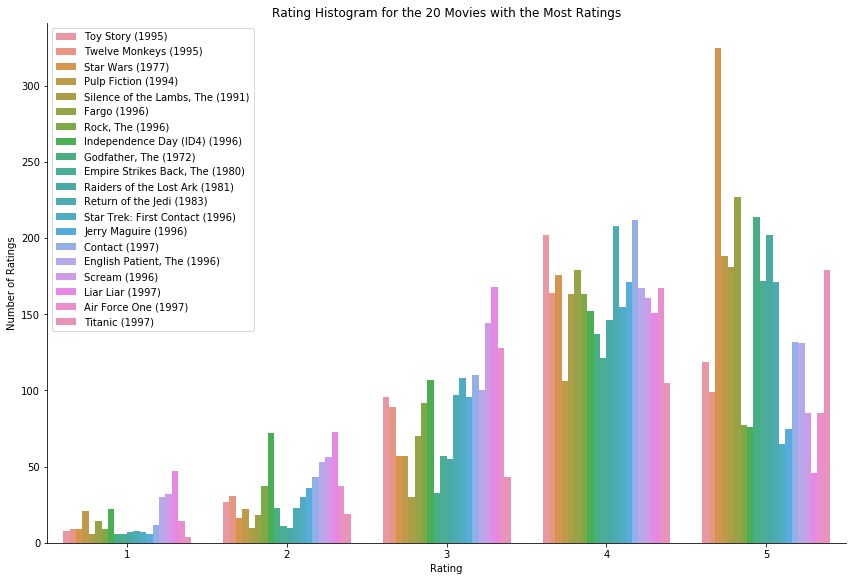

In [15]:
rating_v_count_ax = sns.factorplot(data=rating_counts_by_movie, x='rating', y='count',
                                   hue='movie_title', size=8, aspect=1.5, kind='bar', legend=False)

plt.title('Rating Histogram for the 20 Movies with the Most Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')

plt.legend(title='')

plt.show()

In [17]:

# movie ratings above this threshold will be counted as a "like"
reward_threshold = 4

In [18]:
rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
                      .groupby(['movie_title','liked']) \
                      .sum().head()

movie_id  rating  count
movie_title                     liked                         
Air Force One (1997)            False      1196      10    346
                                True        299       5     85
Contact (1997)                  False      1028      10    377
                                True        257       5    132
Empire Strikes Back, The (1980) False       684      10    195

In [19]:
rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
                      .groupby(['movie_title','liked'], as_index=False) \
                      .sum().head()

,movie_title,liked,movie_id,rating,count
0,Air Force One (1997),False,1196,10,346
1,Air Force One (1997),True,299,5,85
2,Contact (1997),False,1028,10,377
3,Contact (1997),True,257,5,132
4,"Empire Strikes Back, The (1980)",False,684,10,195


In [20]:
total_reward_counts = rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
    .groupby(['movie_id','movie_title','liked'])['count'] \
    .sum() \
    .unstack('liked') \
    .reset_index() \
    .rename(columns={False:'disliked', True:'liked'}) \
    .eval('total = disliked + liked') \
    .eval('like_pct = 100 * liked / total')

In [21]:
total_reward_counts.sort_values('like_pct', ascending=False, inplace=True)
total_reward_counts.head(10)

liked,movie_id,movie_title,disliked,liked,total,like_pct
2,49,Star Wars (1977),258,325,583,55.746141
8,126,"Godfather, The (1972)",199,214,413,51.815981
19,312,Titanic (1997),171,179,350,51.142857
10,173,Raiders of the Lost Ark (1981),218,202,420,48.095238
3,55,Pulp Fiction (1994),206,188,394,47.715736
9,171,"Empire Strikes Back, The (1980)",195,172,367,46.866485
4,97,"Silence of the Lambs, The (1991)",209,181,390,46.410256
5,99,Fargo (1996),281,227,508,44.685039
11,180,Return of the Jedi (1983),336,171,507,33.727811
15,285,"English Patient, The (1996)",350,131,481,27.234927


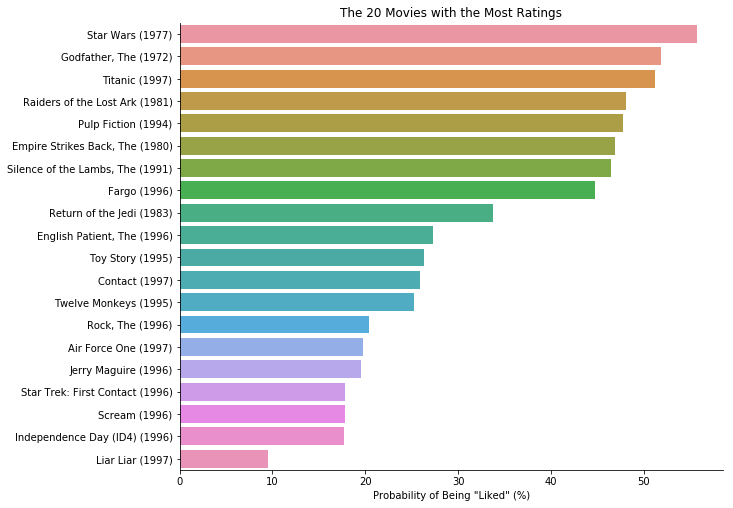

In [26]:

like_probability_ax = sns.factorplot(size=7, aspect=1.5, x='like_pct', y='movie_title', kind='bar', data=total_reward_counts)

plt.title('The 20 Movies with the Most Ratings')
like_probability_ax.set_axis_labels('Probability of Being "Liked" (%)','')

plt.show()

# A/B Testing Method

In [30]:
import numpy as np
import pandas as pd

from Replayers import ABTestReplayer, EpsilonGreedyReplayer, ThompsonSamplingReplayer

In [29]:
! pip install tqdm

    100% |████████████████████████████████| 51kB 2.1MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
top_n_movies.head()

,user_id,movie_id,rating,movie_title
0,185,301,3,L.A. Confidential (1997)
1,61,256,2,Men in Black (1997)
2,199,221,5,Star Trek: First Contact (1996)
3,290,117,2,Twister (1996)
4,307,0,4,Toy Story (1995)


In [38]:
reward_threshold = 4
top_n_movies['reward'] = top_n_movies.eval('rating > @reward_threshold').astype(int)
top_n_movies.head()

,user_id,movie_id,rating,movie_title,reward
0,185,301,3,L.A. Confidential (1997),0
1,61,256,2,Men in Black (1997),0
2,199,221,5,Star Trek: First Contact (1996),1
3,290,117,2,Twister (1996),0
4,307,0,4,Toy Story (1995),0


In [39]:
n_visits = 20000
n_iterations = 20

reward_history = top_n_movies
item_col_name = 'movie_id'
visitor_col_name = 'user_id'
reward_col_name = 'reward'

In [40]:
#A/B Test Simulations

n_test_visits = 1000
ab_1k_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

100%|██████████| 20/20 [56:17<00:00, 199.30s/it] 


In [41]:
ab_1k_results_df = pd.DataFrame(ab_1k_results)
ab_1k_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,0.000000,21,0,0,0,0,268
1,0.000000,256,0,0,0,1,140
2,0.333333,175,0,1,1,2,113
3,0.500000,404,0,1,2,3,933
4,0.400000,120,0,0,2,4,930


In [42]:
ab_1k_results_df.to_csv('ab_test_1k.csv')